In [11]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

dst = os.path.expanduser('~') + '/documents/writing/mcarto_figs/'

In [12]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

Detected 2937 cells
Detected 1365 nuclei


,169,188,199,209,224,227,233,235,236,243,...,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_17G195900,1017,2397,727,307,1012,902,832,1286,1518,320,...,809,1299,181,210,1106,366,681,765,574,771
GLYMA_05G092200,456,1687,637,503,465,481,627,971,684,324,...,654,818,199,407,1065,417,428,711,345,477


In [13]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

In [4]:
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)

bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]
uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

maxbirth

Initial number of life-birth pairs	: 80044

No. of diagrams s.t. H_k had the most persistent component
H_0:	56 [ 3.1% ]
H_1:	136 [ 7.4% ]
H_2:	1644 [ 89.5% ]

Will focus just on dimension k = 2



17.94596854953066

# Bring in persistence images to the party

In [14]:
sigma = 1
pers_w = 1
pixel_size = 1
nameparams = [level, normtype, stepsize, bw, SCALE, sigma, pers_w, pixel_size]

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                       
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
full_img = np.zeros((len(full_lt_coll), len(full_lt_coll[0]), extent[1], extent[3]))
for k in range(len(full_img)):
    full_img[k] = np.asarray(pimgr.transform(full_lt_coll[k], skew=False))
full_img[full_img < 0] = 0

# Pipeline figure

In [15]:
method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
csvfilename = dsrc + 'scale{}_-_PI_{}_{}_{}_pca_{}.csv'.format(SCALE, sigma, pers_w, pixel_size, pname )
print(csvfilename)
embedding = pd.read_csv(csvfilename)
pca = embedding.iloc[:,2:4].values
foo = [bw, stepsize, level.title(), normtype.title(), sigma, pers_w]
Bname = 'KDE bandwidth {}, stepsize {}. {}level persistence. {} normalized. PIs $\sigma = {}$. Weighted by $n^{{{}}}$.'.format(*foo)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_pca_H1+2.csv


# Visualize those differences

In [16]:
original_IDs = [2530, 613, 1544, 2368]
ndimage_ids = np.zeros(len(original_IDs), dtype=int)
reps = np.zeros(2*len(ndimage_ids), dtype=int)

for i in range(len(original_IDs)):
    ndimage_ids[i] = metacell[metacell['orig_cellID'] == original_IDs[i]].index.values[0]
for i in range(len(ndimage_ids)):
    reps[2*i:2*i+2] = embedding[embedding['ndimage_ID'] == ndimage_ids[i]].iloc[[0,-1]].index.values
reps

array([ 912, 1830,  153, 1071,  596, 1514,  885, 1803])

In [17]:
img = full_img[:, reps]
pimax = np.quantile(img[img > 0], 0.995)

KDE, hcells, hcoords, hextent, hzhist = [ [None for _ in range(len(reps))] for _ in range(5) ]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    hcoords[i] = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    hzhist[i], _ = np.histogram(hcoords[i][2], bins=zbins, density=True)

    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], zmax, stepsize, cell_nuc)
       
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    if i%10 == 0:
        print(i)
    hcells[i][pxbar] = -1

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
hzlevel = np.array(list(map(np.argmax, hzhist)))

kmin = np.inf
for i in range(len(hkdes)):
    foo = np.quantile(hkdes[i][hkdes[i] > 0], 0.05)
    if foo < kmin:
        kmin = foo

Kmax= np.max(list(map(np.max, hkdes)))

0


In [18]:
N = 10
thrs = np.linspace(0, Kmax, N)

In [19]:
ndimage_ids

array([2529,  612, 1543, 2367])

In [20]:
for k in range(len(hkdes)):
    fig, ax = plt.subplots( 1,N, figsize=(N*1.5, 1.5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); i = 0
    for i in range(len(thrs)):
        ax[i].imshow(hkdes[k][hzlevel[k],:,:] <= thrs[i], origin='lower', cmap='viridis', vmin=0, vmax=1, zorder=1)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        ax[i].set_facecolor( mpl.colormaps[ 'viridis' ](255) )
        ax[i].set_aspect('equal','datalim')
    plt.subplots_adjust(wspace=0, hspace=0);
    foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
    filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_ph_c{}_{}'.format(*foo)
    print(filename)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0)
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c1544_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c2368_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_ph_c2368_GLYMA_05G092200


In [21]:
for k in range(0, len(hkdes), 2):
    print(k, hkdes[k].max(), hkdes[k].shape[1]/hkdes[k].shape[2], sep='\t')

0	2.235037696087938e-10	1.5324675324675325
2	1.8932338693484582e-10	1.0124223602484472
4	2.1922479130490873e-10	1.7364864864864864
6	2.255854206090539e-10	1.026143790849673


In [22]:
k = 4
for k in range(len(hkdes)):
    fig, ax = plt.subplots( 1,1, figsize=(5, 5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].imshow(hkdes[k][hzlevel[k],:,:], origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1)
    ax[i].set_facecolor( mpl.colormaps[ Cmap ](0) )
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')
    foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
    filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_kde_c{}_{}'.format(*foo)
    print(filename)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0)
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c1544_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c2368_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_kde_c2368_GLYMA_05G092200


In [23]:
for k in range(len(hcells)):
    fig, ax = plt.subplots( 1,1, figsize=(5, 5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[i].scatter(*hcoords[k][:2], color=color[2*(k%2)], marker=marker[2*(k%2)], alpha=0.35, s=int(4e6/hcells[k].size))
    ax[i].set_facecolor(wong[2])
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal','datalim')
    foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
    filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_cell_c{}_{}'.format(*foo)
    print(filename)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0)
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c1544_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c2368_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_cell_c2368_GLYMA_05G092200


In [24]:
aux = 12; fs = 18
k = 1
for k in range(len(reps)):
    fig, ax = plt.subplots(1,1, figsize=(5, 5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); i = 0
    ax[i].set_xlabel('Birth', fontsize=fs)
    ax[i].set_ylabel('Death', fontsize=fs)
    ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=1, lw=3)
    ax[i].set_xticks(range(0,aux+1,3), range(0,aux+1,3))
    ax[i].set_yticks(range(0,aux+1,3), range(0,aux+1,3))
    ax[i].set_xlim(0, aux);ax[i].set_ylim(0, aux)
    for dim in hdims:
        d = full_lt_coll[dim][reps[k]].copy()
        d[:,1] += d[:,0]
        ax[i].scatter(d[:,0], d[:,1], alpha=1, label='$H_{}$'.format(dim), 
                      marker=marker[dim], c=color[2+dim], s=75, linewidth=1, edgecolor='k', zorder=dim+1)
    ax[i].set_aspect('equal','datalim')
    ax[i].legend(loc='lower right', markerscale=1.75, fontsize=fs)
    
    ax[i].tick_params(labelsize=fs)
    ax[i].set_facecolor('snow')
    foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
    filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pd_c{}_{}'.format(*foo)
    print(filename)
    #ax[i].set_rasterized(True)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c1544_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c2368_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pd_c2368_GLYMA_05G092200


In [27]:
for k in range(len(reps)):
    fig, ax = plt.subplots(1,len(hdims), figsize=(4*len(hdims),5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); i = 0
    for i in range(len(ax)):
        ax[i].imshow(img[hdims[i],k].T, cmap=cmap[2+hdims[i]], vmin=0, vmax=pimax, origin='lower')
        ax[i].text((extent[1]-extent[0])*.95, (extent[3]-extent[2])*.95, 
                   '$H_{}$'.format(hdims[i]), color='w', ha='right', va='top', fontsize=1.5*fs)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.subplots_adjust(wspace=0, hspace=0);
    foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
    filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pi_c{}_{}'.format(*foo)
    print(filename)
    fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
    plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c1544_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c2368_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi_c2368_GLYMA_05G092200


In [28]:
for k in range(len(reps)):
    for j in range(len(hdims)):
        fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
        ax = np.atleast_1d(ax).ravel(); i = 0
        ax[i].imshow(img[hdims[j],k].T, cmap=cmap[2+hdims[j]], vmin=0, vmax=pimax, origin='lower')
        ax[i].text((extent[1]-extent[0])*.95, (extent[3]-extent[2])*.95, 
                   '$H_{}$'.format(hdims[j]), color='w', ha='right', va='top', fontsize=1.5*fs)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        plt.subplots_adjust(wspace=0, hspace=0);
        foo = nameparams + [hdims[j], metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
        filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pi{}_c{}_{}'.format(*foo)
        print(filename)
        fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
        plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c2530_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c2530_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c613_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c613_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi1_c1544_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pi2_c1544_GLYMA_17G195900
/hom

In [30]:
foo = list(range(len(embedding[embedding['gene_ID'] == Genes[0]])))
foo += list(range(len(embedding)-len(embedding[embedding['gene_ID'] == Genes[1]]), len(embedding)))
foo = np.array(foo)
pimg = full_img.reshape(full_img.shape[0], full_img.shape[1], full_img.shape[2]*full_img.shape[3])
pimg = pimg[:, foo ]
pimg.shape

(3, 1836, 304)

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pis


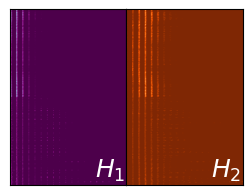

In [31]:
fig, ax = plt.subplots(1,len(hdims), figsize=(3,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(len(ax)):
    ax[i].imshow(pimg[hdims[i]], cmap=cmap[2+hdims[i]], vmin=0, vmax=pimax, origin='lower')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].text(pimg.shape[2]*.99, pimg.shape[1]*.01, 
                   '$H_{}$'.format(i+1), color='w', ha='right', va='bottom', fontsize=fs)
    ax[i].set_aspect(0.25)
plt.subplots_adjust(wspace=0, hspace=0);
foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pis'.format(*foo)
print(filename)
fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);
#plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw20_S16_1_1_1_phs


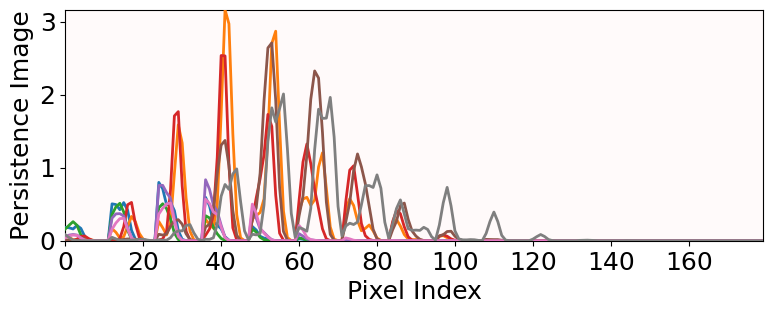

In [300]:
fig, ax = plt.subplots(1, 1, figsize=(9,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(img.shape[1]):
    ax[i].plot(img[2,k].ravel(), lw=2, zorder=k+3)

ax[i].set_facecolor('snow')
ax[i].margins(0)
ax[i].set_xlabel('Pixel Index', fontsize=fs)
ax[i].set_ylabel('Persistence Image', fontsize=fs)
ax[i].tick_params(labelsize=fs)
foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_phs'.format(*foo)
print(filename)
fig.savefig(filename + '.pdf', bbox_inches='tight',transparent=False, pad_inches=0);

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pca


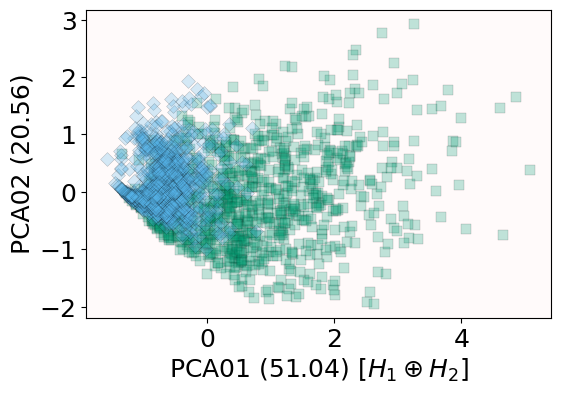

In [33]:
fig, ax = plt.subplots( 1, 1, figsize=(6,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for j in [0,1]:
    foopca = embedding[embedding['gene_ID'] == Genes[j]].iloc[:, [2,3]].values.T
    ax[i].scatter(*foopca, c=color[2*(j%4)], marker=marker[2*(j%4)], s=50, alpha=0.25, zorder=10-j, edgecolor='k', linewidth=0.35)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
ax[i].tick_params(labelsize=fs)
ax[i].set_facecolor('snow')
foo = nameparams + [metacell.loc[embedding.loc[reps[k], 'ndimage_ID'], 'orig_cellID'], transcriptomes[embedding.loc[reps[k], 'gene_ID']] ]
filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pca'.format(*foo)
print(filename)
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Comparing PIs directly ($L_\infty$ norm)

In [35]:
for pcnum in range(2):
    for gidx in [0,1]:
        
        fig, ax = plt.subplots(1, 1, figsize=(7,7), sharex=False, sharey=False)
        ax = np.atleast_1d(ax).ravel(); i = 0
        
        pmask = embedding['gene_ID'] == Genes[gidx]
        cellloc = metacell.loc[ embedding.loc[pmask, 'ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
        c = pca[pmask, pcnum]
        vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
        vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)
        
        ax[i].scatter(wcoords[1], wcoords[0], c='#808080', marker='.', s=0.1, alpha=0.1, zorder=1)
        ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap, label='PC {:02d}'.format(pcnum+1),
                      edgecolor='black', linewidth=0.5, zorder=2, s=80, vmax=vmax, vmin=vmin)
        ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        ax[i].set_aspect('equal','datalim')
        ax[i].legend(loc='upper right', markerscale=1.75, fontsize=fs)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        
        foo = nameparams + [ pcnum+1, transcriptomes[Genes[gidx]] ]
        filename = dst + '{}level_{}_s{}_bw{}_S{}_{}_{}_{}_pca{}_{}'.format(*foo)
        print(filename)
        fig.savefig(filename + '.png', bbox_inches='tight',transparent=False, pad_inches=0);
        plt.close()

/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pca1_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pca1_GLYMA_05G092200
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pca2_GLYMA_17G195900
/home/eah4d/documents/writing/mcarto_figs/sublevel_both_s3_bw25_S32_1_1_1_pca2_GLYMA_05G092200


# Explore